### Outline of the project
---
1. Download and understand the dataset
2. Make a stratified train and validation split of the dataset
3. Normalize the data
4. Load the data into `DataLoader`
5. Create a loss function suiting the dataset
6. Create a neural network model using `nn.Sequential`
7. Create a `Learner` object to automate the training process.
8. Train your model using the custom loss function and `CrossEntropyLossFlat()` provided by `fastai` to show 

In [2]:
from fastai.vision.all import *
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, random_split
from sklearn.model_selection import train_test_split

matplotlib.rc('image', cmap='Greys')

In [3]:
dset = datasets.MNIST(
    root='dset',
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
    download=True
)

print(dset)
print(dset.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: dset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])


In [4]:
print(dset.targets.size())

torch.Size([60000])


In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(dset.data, dset.targets, test_size=0.2, stratify=dset.targets)

(<matplotlib.image.AxesImage at 0x7f59b714c070>, tensor(9))

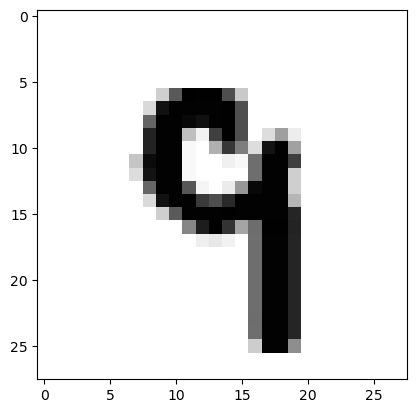

In [6]:
plt.imshow(train_x.numpy()[99]), train_y[99]

In [7]:
train_x = train_x.view(-1, 28*28).float() / 255
valid_x = valid_x.view(-1, 28*28).float() / 255
train_y = train_y.unsqueeze(1)
valid_y = valid_y.unsqueeze(1)
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

(torch.Size([48000, 784]),
 torch.Size([12000, 784]),
 torch.Size([48000, 1]),
 torch.Size([12000, 1]))

In [8]:
train_x[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [9]:
train_y[0]

tensor([9])

In [10]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

len(train_dset), len(valid_dset)

(48000, 12000)

In [11]:
train_dset[0][1]

tensor([9])

In [12]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=False)
dls = DataLoaders(train_dl, valid_dl)

In [13]:
# Original code
# def mnist_loss(preds, targets):
#     preds = preds.sigmoid()
#     loss = []
    
#     for pred, target in zip(preds, targets):
#         for p in range(len(pred)):
#             if p == target:
#                 loss.insert(p, (1 - pred[p])**2)
#             else:
#                 loss.insert(p, pred[p]**2)
#             loss[p] = loss[p].mean().view(1)

#     loss = torch.cat(loss)
#     return loss.mean()

# Optimized code by ChatGPT
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    loss = torch.zeros_like(preds)

    for i, target in enumerate(targets):
        loss[i, target] = (1 - preds[i, target]) ** 2
        loss[i] += preds[i] ** 2

    return loss.mean()

In [14]:
n_net = nn.Sequential(
    nn.Linear(28*28, 250),
    nn.ReLU(),
    nn.Linear(250, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [15]:
learn_mse = Learner(dls, n_net, loss_func=mnist_loss, metrics=accuracy)
learn_mse.fit(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.079181,0.071732,0.694500,01:11
1,0.061072,0.058314,0.902583,01:09
2,0.056647,0.055975,0.926083,01:11
3,0.055173,0.054979,0.937500,01:11


In [37]:
learn_ce = Learner(dls, n_net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn_ce.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.326156,0.276140,0.922250,00:40
1,0.200172,0.205975,0.942417,00:38
2,0.144293,0.157813,0.953750,00:37
3,0.114741,0.133657,0.959750,00:36
4,0.091940,0.120220,0.962333,00:34


`CrossEntropyLossFlat()` clearly performs better than the custom loss function defined previously.

Refer [`mnist1.ipynb`](https://github.com/SuchitG04/mnist/blob/main/mnist1.ipynb) to see the lower-level implementation of functions over two classes of the `MNIST` dataset.